In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

In [6]:
def parse_udp_log(file_path):
    data = []
    with open(file_path, "r") as f:
        for line in f:
            if "Query resolved" in line:
                match = re.search(r"Query resolved: (.+?) for (\d+\.\d+\.\d+\.\d+):(\d+) in (.+?) seconds", line)
                if match:
                    query = match.group(1)
                    client_ip = match.group(2)
                    client_port = match.group(3)
                    response_time = float(match.group(4))
                    timestamp = datetime.strptime(line[:19], "%Y-%m-%d %H:%M:%S")
                    data.append({"query": query, "client_ip": client_ip, "client_port": client_port,
                                 "response_time": response_time, "timestamp": timestamp})
    return pd.DataFrame(data)

In [7]:
def parse_gatekeeper_log(file_path):
    data = []
    with open(file_path, "r") as f:
        for line in f:
            if "Routing query to" in line:
                match = re.search(r"Routing query to (\w+?) server: (.+?) from (\d+\.\d+\.\d+\.\d+)", line)
                if match:
                    server = match.group(1)
                    query = match.group(2)
                    client_ip = match.group(3)
                    timestamp = datetime.strptime(line[:19], "%Y-%m-%d %H:%M:%S")
                    data.append({"server": server, "query": query, "client_ip": client_ip, "timestamp": timestamp})
    return pd.DataFrame(data)


In [8]:
def parse_test_metrics_log(file_path):
    data = []
    with open(file_path, "r") as f:
        for line in f:
            if "Record retrieved" in line or "Zone transfer successful" in line:
                timestamp = datetime.strptime(line[:19], "%Y-%m-%d %H:%M:%S")
                if "Record retrieved" in line:
                    query_type = "Record Lookup"
                    result = re.search(r"Record retrieved: (.+)", line).group(1)
                elif "Zone transfer successful" in line:
                    query_type = "Zone Transfer"
                    result = "Success"
                data.append({"timestamp": timestamp, "query_type": query_type, "result": result})
    return pd.DataFrame(data)


In [9]:
udp_data = parse_udp_log("/Users/harshil/Development/Dev_tests/folder_1/DoS-Secure-DNS-Server/baseline_experimentation/logs/udp_handler.log")
gatekeeper_data = parse_gatekeeper_log("/Users/harshil/Development/Dev_tests/folder_1/DoS-Secure-DNS-Server/baseline_experimentation/logs/dns_gatekeeper.log")
test_metrics_data = parse_test_metrics_log("/Users/harshil/Development/Dev_tests/folder_1/DoS-Secure-DNS-Server/baseline_experimentation/logs/test_metrics.log")


In [10]:
avg_response_time = udp_data["response_time"].mean()
print(f"Average Response Time: {avg_response_time:.4f} seconds")


Average Response Time: 0.0090 seconds


In [11]:
success_count = len(test_metrics_data[test_metrics_data["result"] != "Failure"])
total_tests = len(test_metrics_data)
success_rate = (success_count / total_tests) * 100
print(f"Success Rate: {success_rate:.2f}%")


Success Rate: 100.00%


In [12]:
load_distribution = gatekeeper_data["server"].value_counts(normalize=True) * 100
print("Load Distribution:")
print(load_distribution)


Load Distribution:
server
primary    100.0
Name: proportion, dtype: float64


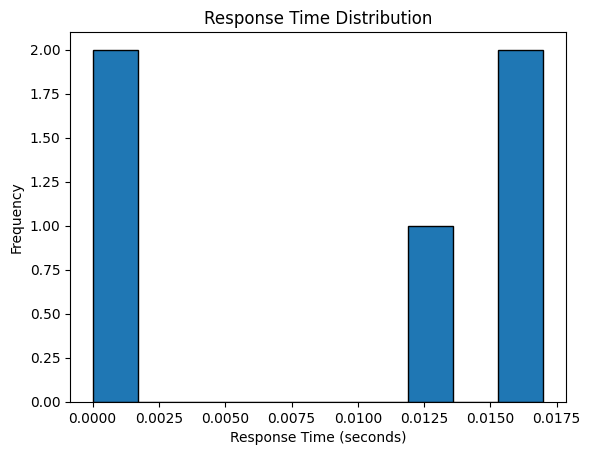

In [13]:
plt.hist(udp_data["response_time"], bins=10, edgecolor="black")
plt.title("Response Time Distribution")
plt.xlabel("Response Time (seconds)")
plt.ylabel("Frequency")
plt.show()


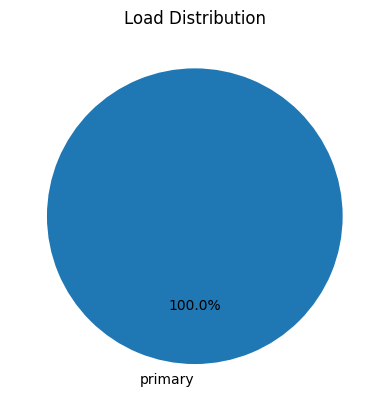

In [14]:
load_distribution.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Load Distribution")
plt.ylabel("")  # Hide the y-label for better visualization
plt.show()


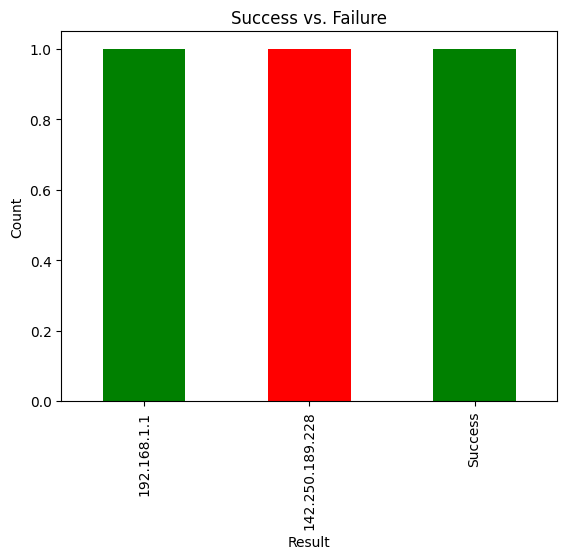

In [15]:
test_metrics_data["result"].value_counts().plot(kind="bar", color=["green", "red"])
plt.title("Success vs. Failure")
plt.xlabel("Result")
plt.ylabel("Count")
plt.show()
